# Hyperparameter tuning

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# Variablen anpassen

# YOLO11 Model
MODEL_PATH = r"C:\Users\jonni\OneDrive\Dokumente\GitHub\AI-Training-Jupyter\runs\train\yolo11n_custom\weights\best.pt"

# TEST-Verzeichnis im Split-Verzeichnis:
DATASET_IMAGES = r"C:\Users\jonni\OneDrive\Dokumente\GitHub\Chairlift_Gefahrenerkennung\01_Data_Jon\Augmented\Images_split\Images\train\images"

ADAPTIVE_STEPS = 100  # Anzahl Feinstufen pro Suchdurchgang
N_ITER = 100          # Wie oft soll die adaptive Suche verengt werden


In [3]:
# CLASS_NAMES aus dem YOLO Modell extrahieren
MODEL = YOLO(MODEL_PATH)
CLASS_NAMES = MODEL.names
N_CLASSES = len(CLASS_NAMES)

print(f"Geladene Klassen: {CLASS_NAMES}")

Geladene Klassen: {0: 'KLEBER', 1: 'EDDING', 2: 'TACKER'}


---

### Tuning starten

Optimiere für Klasse: KLEBER


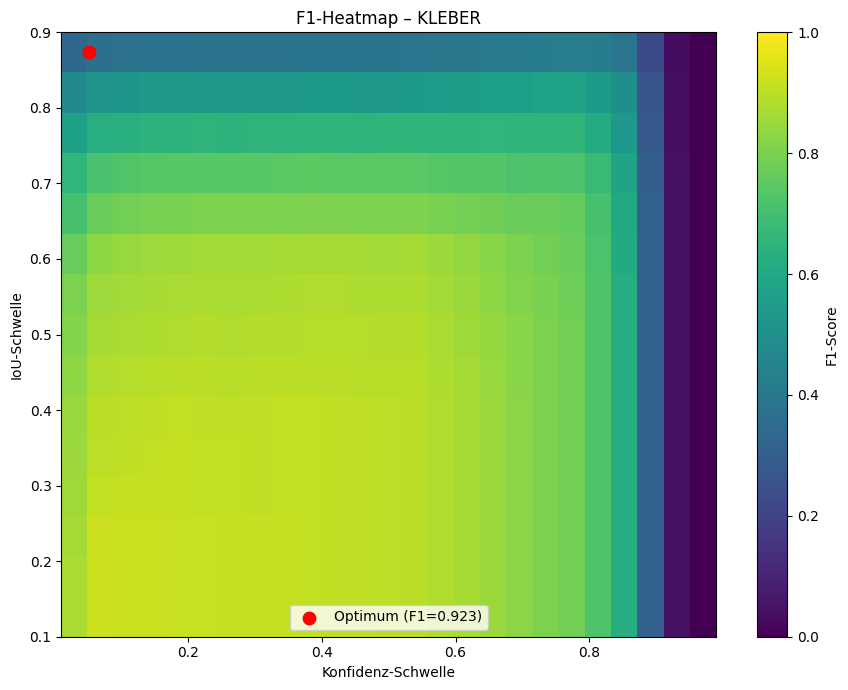

Optimiere für Klasse: EDDING


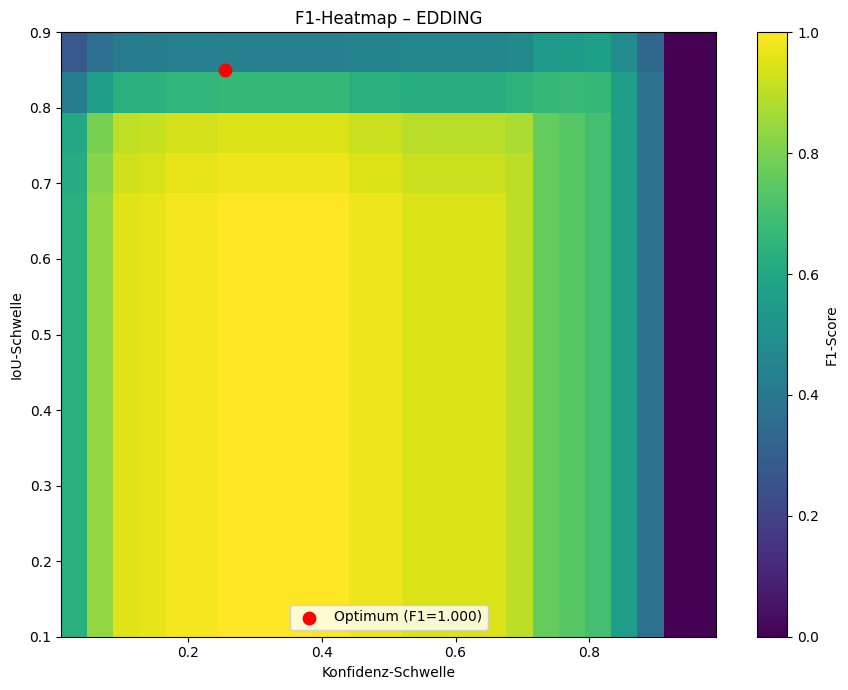

Optimiere für Klasse: TACKER


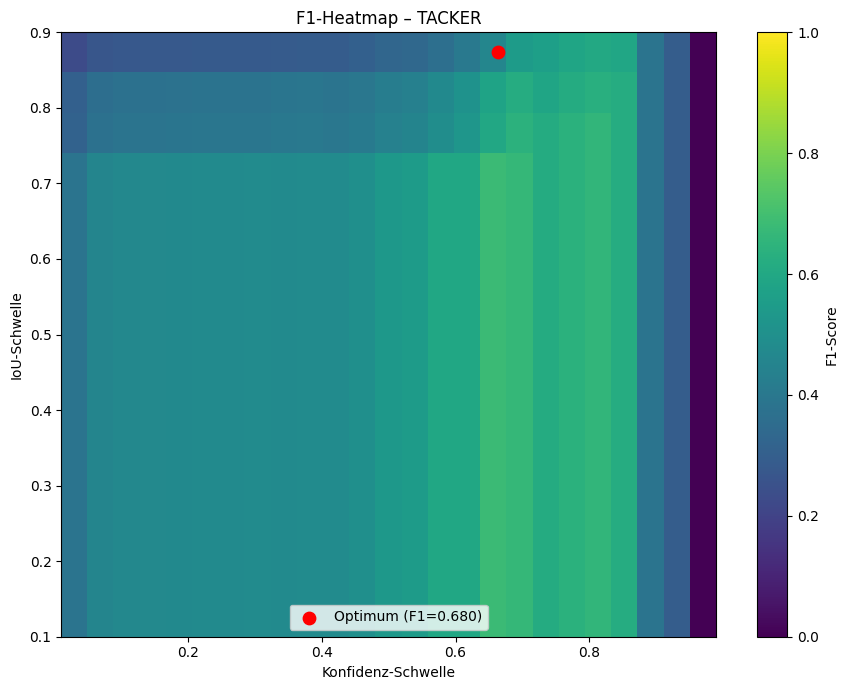

Optimiere für alle Klassen gemeinsam:


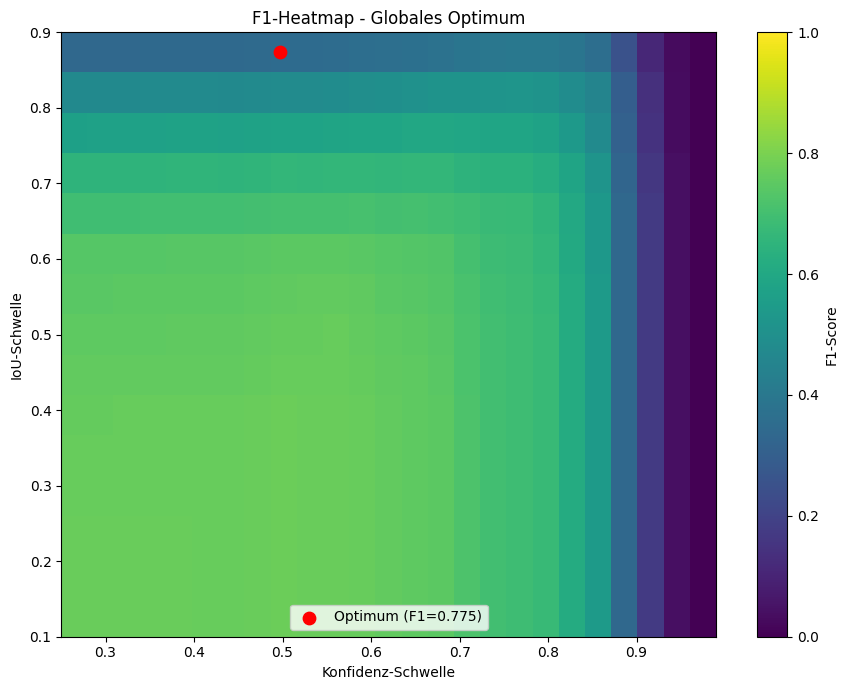

Global best F1=0.775 bei Conf=0.50, IoU=0.94
Fertig: Einzelne und globale Heatmaps sowie CSV-Dateien erzeugt.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from ultralytics import YOLO

# Helper: Adaptiver Bereich für Feinabstimmung (wird hier für Heatmap nicht genutzt)
def adaptive_range(start, stop, n=3, around=None, spread=0.1):
    if around is not None:
        span = (stop - start) * spread
        values = np.linspace(max(start, around-span), min(stop, around+span), n)
    else:
        values = np.linspace(start, stop, n)
    return values

# Helper: Find label path for each image (robust für Windows/Linux)
def get_label_path(img_path):
    dir_path, file_name = os.path.split(img_path)
    dir_path_labels = dir_path.replace(f"{os.sep}images", f"{os.sep}labels")
    base, _ = os.path.splitext(file_name)
    label_path = os.path.join(dir_path_labels, base + ".txt")
    return label_path

def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = max(1e-8, (box1[2] - box1[0]) * (box1[3] - box1[1]))
    box2Area = max(1e-8, (box2[2] - box2[0]) * (box2[3] - box2[1]))
    iou = interArea / float(box1Area + box2Area - interArea + 1e-8)
    return iou

# 1. Groundtruths & Predictions sammeln
model = YOLO(MODEL_PATH)
results = model.predict(DATASET_IMAGES, save=False, conf=0.01, iou=0.1, stream=True, verbose=False)
all_img_paths, all_preds, all_gts = [], [], []

for r in results:
    img_path = r.path
    all_img_paths.append(img_path)
    boxes = r.boxes.xyxy.cpu().numpy() if r.boxes is not None else np.zeros((0,4))
    scores = r.boxes.conf.cpu().numpy() if r.boxes is not None else np.zeros((0,))
    classes = r.boxes.cls.cpu().numpy().astype(int) if r.boxes is not None else np.zeros((0,))
    all_preds.append({'boxes': boxes, 'scores': scores, 'classes': classes})
    # Labels (YOLO txt → xyxy)
    label_path = get_label_path(img_path)
    gts = []
    if os.path.isfile(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls, x, y, w, h = int(float(parts[0])), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                img = plt.imread(img_path)
                h_img, w_img = img.shape[:2]
                cx, cy = x*w_img, y*h_img
                bw, bh = w*w_img, h*h_img
                x1, y1 = max(0, cx-bw/2), max(0, cy-bh/2)
                x2, y2 = min(w_img, cx+bw/2), min(h_img, cy+bh/2)
                gts.append([cls, x1, y1, x2, y2])
    all_gts.append(np.array(gts))

# ---- A) Optimale Werte pro Klasse ----
optim_results = []
for k in range(N_CLASSES):
    print(f"Optimiere für Klasse: {CLASS_NAMES[k]}")
    conf_values = np.linspace(0.01, 0.99, 25)
    iou_values = np.linspace(0.1, 0.9, 15)
    best_f1 = 0.0
    best_conf, best_iou = 0.25, 0.5
    f1_grid = np.zeros((len(iou_values), len(conf_values)))
    for i, iou_thr in enumerate(iou_values):
        for j, conf_thr in enumerate(conf_values):
            TP, FP, FN = 0, 0, 0
            for preds, gts in zip(all_preds, all_gts):
                pred_idx = (preds['classes'] == k) & (preds['scores'] >= conf_thr)
                pred_boxes = preds['boxes'][pred_idx]
                gt_boxes = gts[gts[:, 0] == k][:, 1:] if gts.size > 0 else np.empty((0, 4))
                used_gt = set()
                for p_i, pb in enumerate(pred_boxes):
                    best_iou = 0
                    best_j = -1
                    for g_j, gb in enumerate(gt_boxes):
                        if g_j in used_gt:
                            continue
                        iou = compute_iou(pb, gb)
                        if iou > best_iou:
                            best_iou = iou
                            best_j = g_j
                    if best_iou >= iou_thr and best_j >= 0:
                        TP += 1
                        used_gt.add(best_j)
                    else:
                        FP += 1
                FN += len(gt_boxes) - len(used_gt)
            precision = TP / (TP + FP + 1e-8)
            recall = TP / (TP + FN + 1e-8)
            f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision + recall) > 0 else 0
            f1_grid[i, j] = f1
            if f1 > best_f1:
                best_f1 = f1
                best_conf = conf_values[j]
                best_iou = iou_values[i]
    optim_results.append({'Klasse': CLASS_NAMES[k], 'Best_Conf': best_conf, 'Best_IoU': best_iou, 'Best_F1': best_f1})
    # Plot pro Klasse
    plt.figure(figsize=(9, 7))
    plt.imshow(
        f1_grid, aspect='auto', origin='lower',
        extent=[conf_values[0], conf_values[-1], iou_values[0], iou_values[-1]],
        cmap='viridis', vmin=0, vmax=1
    )
    plt.colorbar(label="F1-Score")
    # Optimum nicht auf die Kante setzen
    offset_x = (conf_values[-1] - conf_values[0]) / (2*len(conf_values))
    offset_y = (iou_values[-1] - iou_values[0]) / (2*len(iou_values))
    plot_conf = min(max(best_conf, conf_values[0] + offset_x), conf_values[-1] - offset_x)
    plot_iou = min(max(best_iou, iou_values[0] + offset_y), iou_values[-1] - offset_y)
    plt.scatter([plot_conf], [plot_iou], c='red', s=80, label=f"Optimum (F1={best_f1:.3f})")
    plt.xlabel("Konfidenz-Schwelle")
    plt.ylabel("IoU-Schwelle")
    plt.ylim(iou_values[0], iou_values[-1])
    plt.xlim(conf_values[0], conf_values[-1])
    plt.title(f"F1-Heatmap – {CLASS_NAMES[k]}")
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.savefig(f"f1_heatmap_{CLASS_NAMES[k]}.png")
    plt.show()
    plt.close()

    df = pd.DataFrame(optim_results)
    df.to_csv("conf_iou_tuning_per_class.csv", sep=';', index=False)

# ---- B) Globales Optimum für alle Klassen gemeinsam ----
print("Optimiere für alle Klassen gemeinsam:")
conf_values = np.linspace(0.25, 0.99, 25)
iou_values = np.linspace(0.1, 0.9, 15)
best_f1 = 0.0
best_conf, best_iou = 0.25, 0.5
f1_grid_global = np.zeros((len(iou_values), len(conf_values)))
for i, iou_thr in enumerate(iou_values):
    for j, conf_thr in enumerate(conf_values):
        TP, FP, FN = 0, 0, 0
        for preds, gts in zip(all_preds, all_gts):
            pred_idx = (preds['scores'] >= conf_thr)
            pred_boxes = preds['boxes'][pred_idx]
            pred_classes = preds['classes'][pred_idx]
            gt_boxes = gts[:, 1:] if gts.size > 0 else np.empty((0, 4))
            gt_classes = gts[:, 0] if gts.size > 0 else np.array([])
            used_gt = set()
            for p_i, pb in enumerate(pred_boxes):
                best_iou = 0
                best_j = -1
                for g_j, gb in enumerate(gt_boxes):
                    if g_j in used_gt or pred_classes[p_i] != gt_classes[g_j]:
                        continue
                    iou = compute_iou(pb, gb)
                    if iou > best_iou:
                        best_iou = iou
                        best_j = g_j
                if best_iou >= iou_thr and best_j >= 0:
                    TP += 1
                    used_gt.add(best_j)
                else:
                    FP += 1
            FN += len(gt_boxes) - len(used_gt)
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision + recall) > 0 else 0
        f1_grid_global[i, j] = f1
        if f1 > best_f1:
            best_f1 = f1
            best_conf = conf_values[j]
            best_iou = iou_values[i]
# Plot globales Optimum
plt.figure(figsize=(9, 7))
plt.imshow(
    f1_grid_global,
    aspect='auto', origin='lower',
    extent=[conf_values[0], conf_values[-1], iou_values[0], iou_values[-1]],
    cmap='viridis', vmin=0, vmax=1
)
plt.colorbar(label="F1-Score")
offset_x = (conf_values[-1] - conf_values[0]) / (2*len(conf_values))
offset_y = (iou_values[-1] - iou_values[0]) / (2*len(iou_values))
plot_conf = min(max(best_conf, conf_values[0] + offset_x), conf_values[-1] - offset_x)
plot_iou = min(max(best_iou, iou_values[0] + offset_y), iou_values[-1] - offset_y)
plt.scatter([plot_conf], [plot_iou], c='red', s=80, label=f"Optimum (F1={best_f1:.3f})")
plt.xlabel("Konfidenz-Schwelle")
plt.ylabel("IoU-Schwelle")
plt.ylim(iou_values[0], iou_values[-1])
plt.xlim(conf_values[0], conf_values[-1])
plt.title(f"F1-Heatmap - Globales Optimum")
plt.legend(loc='lower center')
plt.tight_layout()
plt.savefig(f"f1_heatmap_GLOBAL.png")
plt.show()
plt.close()

print(f"Global best F1={best_f1:.3f} bei Conf={best_conf:.2f}, IoU={best_iou:.2f}")
print("Fertig: Einzelne und globale Heatmaps sowie CSV-Dateien erzeugt.")
